## Add stylegan3 repository to python path

In [1]:
import os
import sys

sys.path.append(os.path.join("stylegan3"))

In [2]:
import pickle
import torch
import random
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision import datasets
import torchvision.utils as vutils
from tqdm import tqdm
from torch import optim

In [3]:
BATCH_SIZE = 256
IMG_SIZE = (256, 256)
IMG_CHANNELS = 3
LEARNING_RATE = 0.0002
# Beta1 for Adam
BETA1 = 0.5
NUM_EPOCHS = 30
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Random Seed:  999


## Download architecture from original NVidia repo

In [4]:
try:
    if not "stylegan3-t-ffhqu-256x256.pkl" in os.listdir("StyleGAN3_weights"):
        raise Exception("Not downloaded yet")
    else:
        print("Using existing model")
except:
    print("Downloading the model")
    !curl -LO "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhqu-256x256.pkl"
    !mkdir StyleGAN3_weights
    !copy "stylegan3-t-ffhqu-256x256.pkl" "StyleGAN3_weights/stylegan3-t-ffhqu-256x256.pkl"
    ! del stylegan3-t-ffhqu-256x256.pkl

Using existing model


In [5]:
with open(os.path.join("StyleGAN3_weights", "stylegan3-t-ffhqu-256x256.pkl"), 'rb') as f:
    content = pickle.load(f)
    G = content['G']  # torch.nn.Module
    D = content['D']  # torch.nn.Module
z = torch.randn([1, G.z_dim])  # latent codes
c = None  # class labels (not used in this example)
img = G(z, c)

## Pretrained NVidia demo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


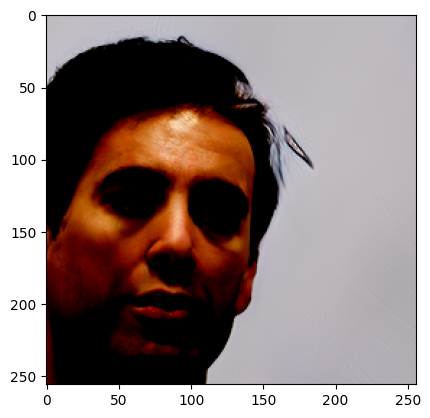

In [6]:
plt.imshow(img.squeeze().numpy().transpose(1, 2, 0))

## Reset weights

In [16]:
def weights_reset(m):
    for name, param in m.named_parameters():
        if name.find('weight') != -1:
            nn.init.normal_(param)
        elif name.find('bias') != -1:
            nn.init.constant_(param, 0)


def enable_gradient(m):
    for name, param in m.named_parameters():
        param.requires_grad = True

def change_latent_dim(generator, new_dim):
    generator.z_dim = new_dim
    generator.mapping.z_dim = new_dim
    generator.mapping.fc0.in_features = new_dim
    generator.mapping.fc0.weights = torch.randn(512, new_dim)
    generator.mapping.fc0.weight = nn.Parameter(data=generator.mapping.fc0.weights)

In [6]:
weights_reset(G)
weights_reset(D)
enable_gradient(G)
enable_gradient(D)

NameError: name 'G' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


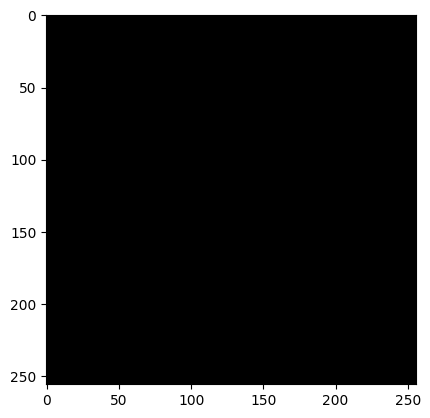

In [10]:
plt.imshow(G(z, c).detach().squeeze().numpy().transpose(1, 2, 0))

## Train on lsun bedrooms

In [7]:
dataset = datasets.ImageFolder("lsun_bedroom", transform=transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

E:\Studies\DataScience-1sem\DeepLearning\venv\lib\site-packages\torch\utils\data\dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# Initialize the ``BCELoss`` function
criterion = nn.BCEWithLogitsLoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

In [10]:
@torch.enable_grad()
def fit_gan(netG, netD, optimizerG, optimizerD, num_epachs, criterion, fixed_noise, latent_dim):
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in tqdm(range(num_epachs)):
        # For each batch in the dataloader
        for i, data in enumerate(loader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu, real_label).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, latent_dim, device=device)
            # Generate fake image batch with G
            fake = netG(noise, None)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach(), None).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake, None).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epachs, i, len(loader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epachs - 1) and (i == len(loader) - 1)):
                with torch.no_grad():
                    fake = netG(fixed_noise, None).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    return {
        'generator': netG,
        'discriminator': netD,
        'images': img_list,
        'D_losses': D_losses,
        'G_losses': G_losses
    }


def save_models(results_dict, path):
    torch.save(results_dict["generator"], os.path.join(path, 'generator'))
    torch.save(results_dict["discriminator"], os.path.join(path, 'generator'))


def save_images(results_dict, path):
    with open(os.path.join(path, "images.pkl"), "wb") as f:
        pickle.dump(results_dict['images'], f)


def save_losses(results_dict, path):
    with open(os.path.join(path, "loss_D.pkl"), "wb") as f:
        pickle.dump(results_dict['D_losses'], f)
    with open(os.path.join(path, "loss_G.pkl"), "wb") as f:
        pickle.dump(results_dict['G_losses'], f)

In [17]:
latent_dims = [16, 128, 512]

for latent_dim in latent_dims:

    with open(os.path.join("StyleGAN3_weights", "stylegan3-t-ffhqu-256x256.pkl"), 'rb') as f:
        content = pickle.load(f)
        G = content['G']  # torch.nn.Module
        D = content['D']  # torch.nn.Module

    weights_reset(G)
    weights_reset(D)
    enable_gradient(G)
    enable_gradient(D)
    if latent_dim != 512:
        change_latent_dim(G, latent_dim)
    G = G.to(device)
    D = D.to(device)

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
    optimizerG = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, G.z_dim, device=device)
    print(f"Started training for latent space dimension = {G.z_dim}")
    with torch.set_grad_enabled(True):
        results = fit_gan(G, D, optimizerG, optimizerD, NUM_EPOCHS, criterion, fixed_noise, G.z_dim)
    path_to_save = os.path.join("GANs", f"StyleGAN3_{G.z_dim}")
    save_models(results, path_to_save)
    save_images(results, path_to_save)
    save_losses(results, path_to_save)

Started training for latent space dimension = 16
Starting Training Loop...


  0%|          | 0/30 [00:00<?, ?it/s]E:\Studies\DataScience-1sem\DeepLearning\venv\lib\site-packages\torch\utils\data\dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


batch 0
[0/30][0/538725]	Loss_D: 1.5055	Loss_G: 0.6918	D(x): -0.2257	D(G(z)): 0.0000 / 0.0028
batch 1


  0%|          | 0/30 [01:38<?, ?it/s]


KeyboardInterrupt: 